# Potencial de paragem

Tensão de paragem para o LED 1: 1.3096 V ± 0.20%
Tensão de paragem para o LED 2: 1.1387 V ± 0.13%
Tensão de paragem para o LED 3: 0.8578 V ± 0.11%
Tensão de paragem para o LED 4: 0.7506 V ± 0.03%
Tensão de paragem para o LED 5: 0.6557 V ± 0.53%
Tensão de paragem para o LED 6: 0.3570 V ± 138.00%
Tensão de paragem para o LED 7: 0.2892 V ± 4.59%
Tensão de paragem para o LED 8: 0.2246 V ± 5.08%
Tensão de paragem para o LED 10: 0.3557 V ± 5.28%
Tensão de paragem para o LED 11: 0.6730 V ± 0.10%


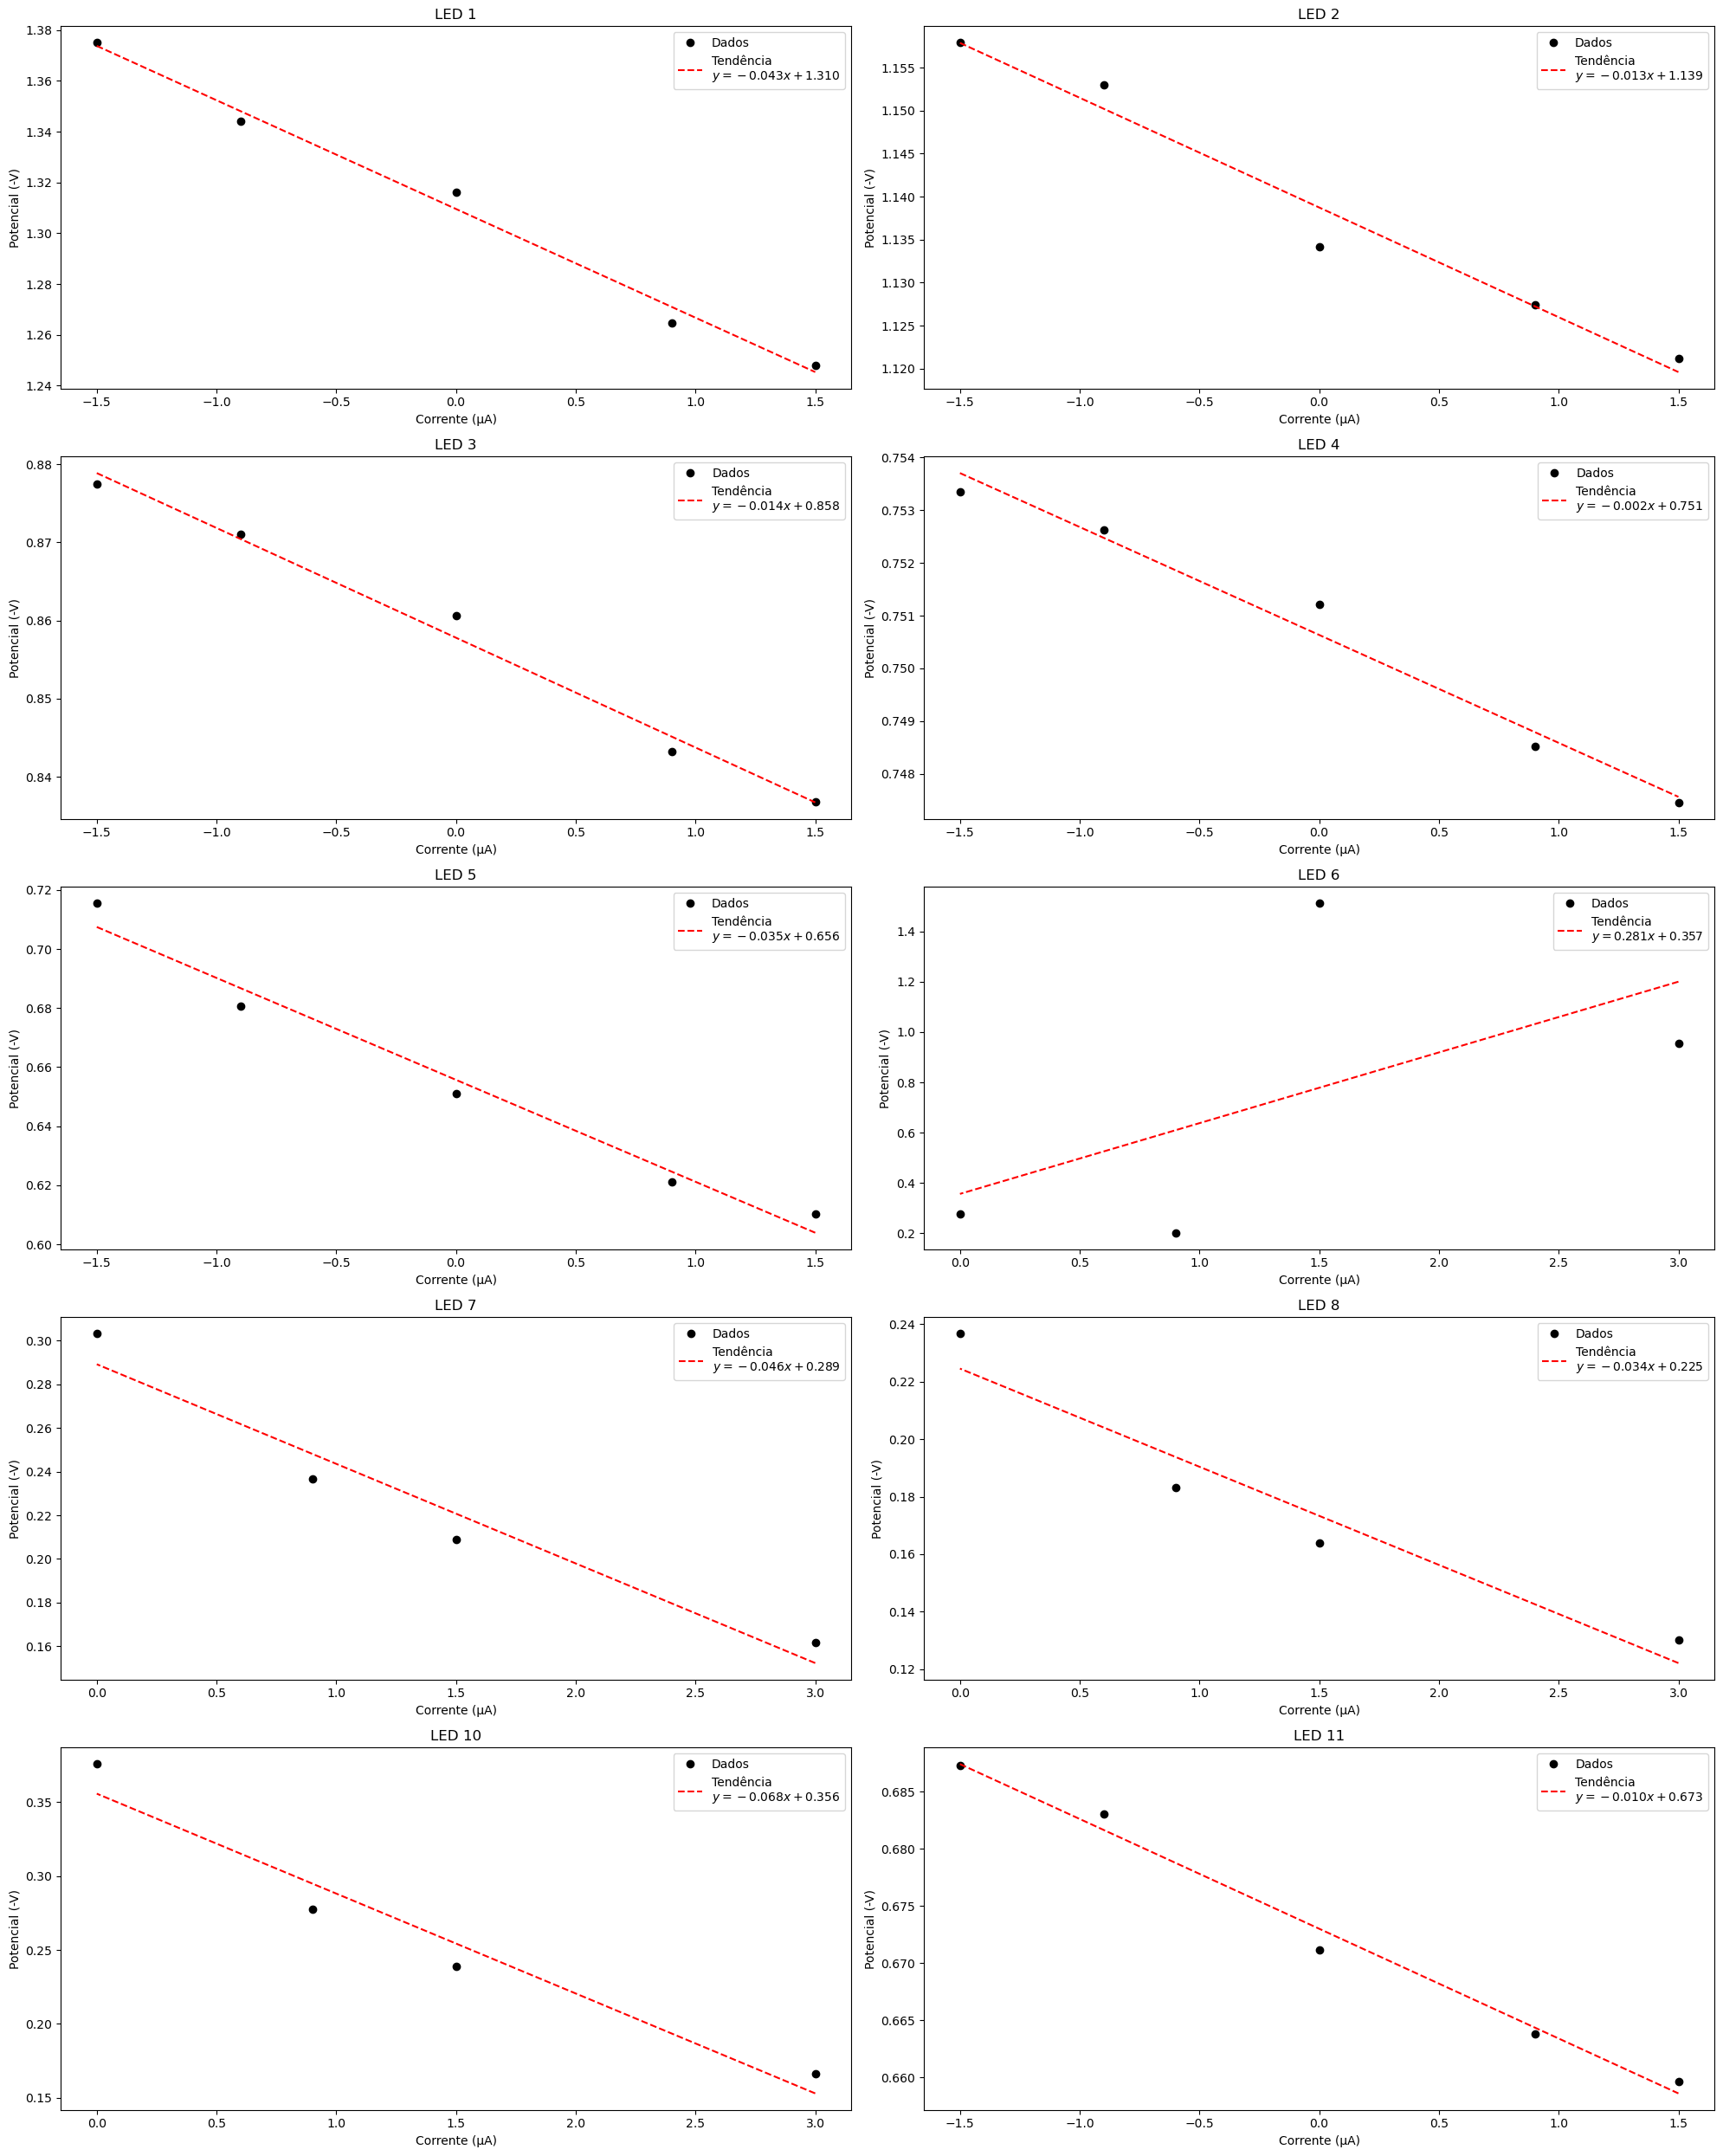

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Definir os índices dos LEDs
led_indices = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11]

# Configurar subplots
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))
axs = axs.flatten()  # Flatten para iteração fácil

# Iterar pelos LEDs e gerar os gráficos
for idx, led in enumerate(led_indices):
    file_name = f"/Users/emanuelmiranda/Desktop/Exp2/Dados/Led {led}.csv"
    try:
        # Ler o ficheiro com separador ajustado
        data = pd.read_csv(file_name, sep=";")  # Ajuste para o separador correto

        # Extrair as colunas
        I = data['I (0,3μA)'].values.reshape(-1, 1)  # Converter para matriz
        I = I * 0.3  # Multiplicar todos os valores de I por 0.3
        V = data['-V (V)'].values

        # Ajustar uma linha de tendência (regressão linear)
        model = LinearRegression()
        model.fit(I, V)
        trend_line = model.predict(I)

        # Determinar a tensão quando a corrente é zero (intercepto)
        intercept = model.intercept_
        slope = model.coef_[0]

        # Calcular os resíduos e o erro padrão dos coeficientes
        residuals = V - trend_line
        s_res = np.sqrt(np.sum(residuals**2) / (len(V) - 2))  # Erro quadrático médio (S_res)
        var_x = np.sum((I - np.mean(I))**2)  # Soma dos quadrados das diferenças
        intercept_error = s_res * np.sqrt(1/len(I) + np.mean(I)**2 / var_x)
        slope_error = s_res / np.sqrt(var_x)

        # Calcular as incertezas em percentagem
        intercept_percent_error = (intercept_error / intercept) * 100
        slope_percent_error = (slope_error / slope) * 100

        # Mostrar os resultados com incertezas
        print(f"Tensão de paragem para o LED {led}: {intercept:.4f} V ± {intercept_percent_error:.2f}%")

        # Gerar gráfico
        ax = axs[idx]
        ax.plot(I, V, 'o', color='black', label='Dados')
        ax.plot(I, trend_line, '--', color='red', label=f'Tendência\n$y = {slope:.3f}x + {intercept:.3f}$')
        ax.set_title(f"LED {led}")
        ax.set_xlabel("Corrente (μA)")  # Corrente ajustada
        ax.set_ylabel("Potencial (-V)")
        ax.legend()
    except Exception as e:
        print(f"Erro ao processar {file_name}: {e}")

# Ajustar layout
plt.tight_layout()
plt.show()

# Varrimento Led 2

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Nome do ficheiro
file_name = "/Users/emanuelmiranda/Desktop/Exp2/Dados/Led 2 Varrimento.csv"

# Função exponencial decrescente
def exp_decay(I, a, b, c):
    return a * np.exp(-b * I) + c

try:
    # Ler o ficheiro com separador ajustado
    data = pd.read_csv(file_name, sep=";")  # Ajuste para o separador correto

    # Extrair as colunas
    I = data['I (0,3μA)'].values  # Corrente
    V = data['-V (V)'].values     # Potencial

    # Ajustar os dados à função exponencial decrescente
    initial_guess = [1, 1, 0]  # Palpite inicial para os parâmetros [a, b, c]
    params, covariance = curve_fit(exp_decay, I, V, p0=initial_guess)

    # Parâmetros ajustados
    a, b, c = params
    print(f"Parâmetros ajustados: a = {a:.10f}, b = {b:.4f}, c = {c:.4f}")

    # Calcular valores ajustados e R^2
    V_fit = exp_decay(I, a, b, c)
    r2_exp = r2_score(V, V_fit)
    print(f"R^2 do ajuste exponencial: {r2_exp:.4f}")

    # Determinar tensão para I = 0
    V_at_zero = exp_decay(0, a, b, c)
    print(f"Tensão para I=0 no ajuste exponencial: {V_at_zero:.4f} V")

    # Escala logarítmica para o ajuste linear
    V_minus_c = V - c  # Subtrai-se o termo c para garantir log válido

    # Verifica se há valores negativos ou zero em V - c
    valid_mask = V_minus_c > 0
    I_valid = I[valid_mask]
    V_valid = V_minus_c[valid_mask]

    # Aplicar o logaritmo apenas nos valores válidos
    log_V_valid = np.log(V_valid)

    # Ajuste linear na escala logarítmica
    linear_coeffs = np.polyfit(I_valid, log_V_valid, 1)
    linear_fit = np.poly1d(linear_coeffs)
    log_V_fit = linear_fit(I_valid)

    # R^2 para o ajuste linear
    r2_linear = r2_score(log_V_valid, log_V_fit)
    print(f"R^2 do ajuste linear (logarítmico): {r2_linear:.4f}")

    # Criar subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Gráfico 1: Escala normal
    axes[0].plot(I, V, 'o', color='black', label='Dados Experimentais')
    axes[0].plot(I, V_fit, '--', color='r', label=f'Ajuste Exponencial\n$V = {a:.2f}e^{{-{b:.2f}I}} + {c:.2f}$\n$R^2 = {r2_exp:.4f}$')
    axes[0].set_title("Escala Normal")
    axes[0].set_xlabel("Corrente (0,3 μA)")
    axes[0].set_ylabel("Potencial (-V)")
    axes[0].legend()

    # Gráfico 2: Escala logarítmica (linearizada)
    axes[1].plot(I_valid, log_V_valid, 'o',color='black', label='Dados (log)')
    axes[1].plot(I_valid, log_V_fit, '--', color='r', label=f'Ajuste Linear\n$y = {linear_coeffs[0]:.2f}x + {linear_coeffs[1]:.2f}$\n$R^2 = {r2_linear:.4f}$')
    axes[1].set_title("Escala Logarítmica (Linearizada)")
    axes[1].set_xlabel("Corrente (0,3 μA)")
    axes[1].set_ylabel("ln(V - c)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Erro ao processar {file_name}: {e}")

Parâmetros ajustados: a = 0.0000000000, b = 1.0521, c = 1.1061
Erro ao processar /Users/emanuelmiranda/Desktop/Exp2/Dados/Led 2 Varrimento.csv: name 'r2_score' is not defined


# Leds

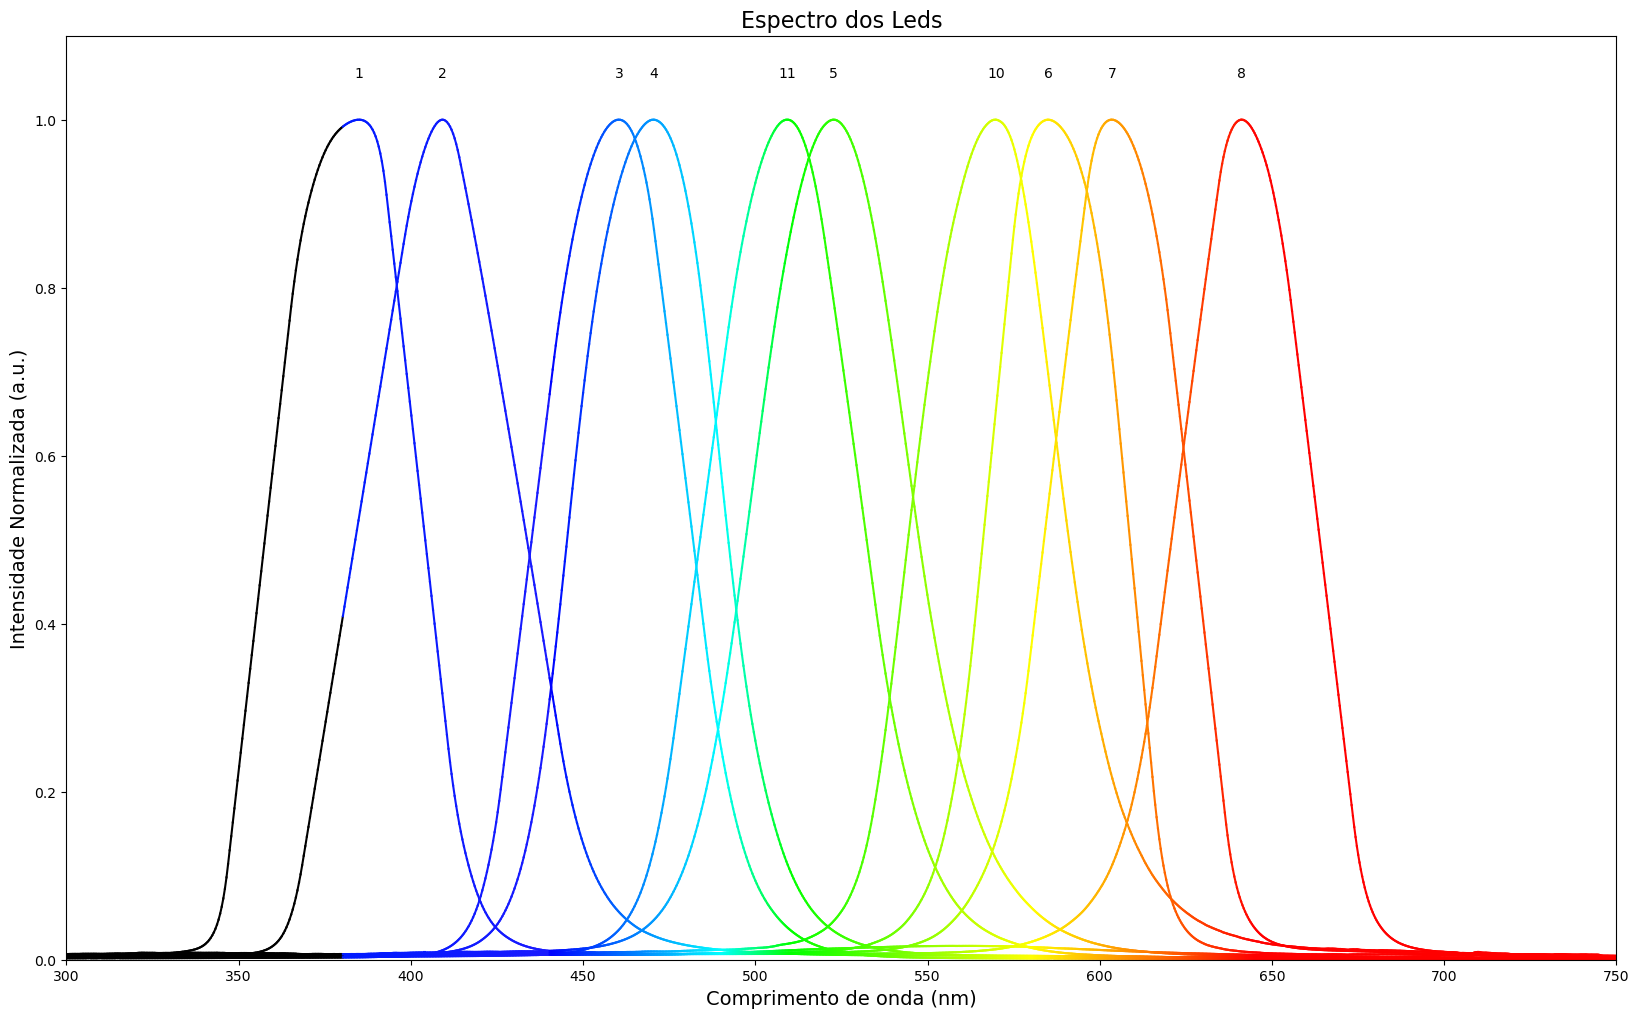

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Função para ler os dados de cada ficheiro
def carregar_dados(arquivo):
    wavelengths = []
    intensities = []
    try:
        with open(arquivo, "r") as data:
            read_data = False  # Sinalizador para começar a ler após o cabeçalho
            for line in data:
                # Verifica se chegamos à linha de dados
                if line.startswith("Pixel"):
                    read_data = True  # Inicia a leitura de dados na próxima linha
                    continue
                if read_data:
                    linha = line.strip().split()  # Divide por espaços ou tabulações
                    if len(linha) == 3:  # Verifica se há exatamente 3 colunas de dados
                        try:
                            wavelength = float(linha[1])  # Coluna 2 é Wavelength
                            intensity = float(linha[2])  # Coluna 3 é Intensity
                            wavelengths.append(wavelength)
                            intensities.append(intensity)
                        except ValueError:
                            print(f"Erro ao converter para float: {linha}")
    except FileNotFoundError:
        print(f"Arquivo {arquivo} não encontrado. Verifique o caminho.")
    return np.array(wavelengths), np.array(intensities)

# Criar o gráfico principal
plt.figure(figsize=(20, 12))

# Iterar sobre os números de 1 a 11, excluindo o 9
for i in range(1, 12):
    if i == 9:
        continue  # Pula o ficheiro 'led9.txt'
    
    arquivo = f"/Users/emanuelmiranda/Desktop/Exp2/Dados/led{i}.txt"  # Caminho para o ficheiro
    wavelengths, intensities = carregar_dados(arquivo)
    
    if wavelengths.size > 0 and intensities.size > 0:
        # Filtrar os valores na faixa de 900 a 1100 nm
        faixa_mask = (wavelengths >= 900) & (wavelengths <= 1100)
        media_faixa = np.mean(intensities[faixa_mask])  # Calcula a média das intensidades nessa faixa
        
        # Subtrair a média de todas as intensidades
        intensities_corrigidas = intensities - media_faixa
        
        # Normalizar as intensidades para que o pico seja igual a 1
        intensidade_max = np.max(intensities_corrigidas)  # Encontra o valor máximo
        if intensidade_max != 0:  # Evita divisão por zero
            intensities_normalizadas = intensities_corrigidas / intensidade_max
        else:
            intensities_normalizadas = intensities_corrigidas  # Caso o valor máximo seja zero

        # Função de mapeamento de cores
        def wavelength_to_rgb(wavelength):
            """Converte um comprimento de onda em uma cor RGB"""
            if wavelength < 380:
                return (0, 0, 0)  # Preto para comprimentos de onda abaixo de 380 nm
            elif wavelength < 440:
                return (0.1 * (wavelength - 380) / (440 - 380), 0.1, 1)  # Azul
            elif wavelength < 490:
                return (0, (wavelength - 440) / (490 - 440), 1)  # Azul a verde
            elif wavelength < 510:
                return (0, 1, (510 - wavelength) / (510 - 490))  # Verde
            elif wavelength < 580:
                return ((wavelength - 510) / (580 - 510), 1, 0)  # Verde a amarelo
            elif wavelength < 645:
                return (1, (645 - wavelength) / (645 - 580), 0)  # Amarelo a vermelho
            elif wavelength <= 780:
                return (1, 0, 0)  # Vermelho
            else:
                return (0, 0, 0)  # Preto para comprimentos de onda acima de 780 nm

        # Plotar os segmentos de linhas com cores de acordo com os comprimentos de onda
        for j in range(len(wavelengths) - 1):
            # Aplique a cor amarela a 589 nm
            if 589 <= wavelengths[j] <= 589.5:  # Verifica se está na vizinhança de 589 nm
                plt.plot(wavelengths[j:j + 2], intensities_normalizadas[j:j + 2], color='#ffe200')  # Cor amarela
            else:
                plt.plot(wavelengths[j:j + 2], intensities_normalizadas[j:j + 2], color=wavelength_to_rgb(wavelengths[j]))

        # Encontrar o pico e a posição do pico
        pico_idx = np.argmax(intensities_normalizadas)
        pico_wavelength = wavelengths[pico_idx]
        pico_intensity = intensities_normalizadas[pico_idx]
        
        # Adicionar o número do LED sobre o pico
        plt.text(pico_wavelength, pico_intensity + 0.05, f'{i}', ha='center', fontsize=10, color='black')

# Título e rótulos
plt.title('Espectro dos Leds', fontsize=16)
plt.xlabel('Comprimento de onda (nm)', fontsize=14)
plt.ylabel('Intensidade Normalizada (a.u.)', fontsize=14)

# Ajusta o limite do eixo x para começar em 500 nm
plt.xlim(300, 750)

# Ajusta o limite do eixo y para começar em 0 (eliminar intensidades negativas)
plt.ylim(0, 1.1)  # Limita o eixo y para não ultrapassar o valor 1 após a normalização

# Exibir o gráfico
plt.show()

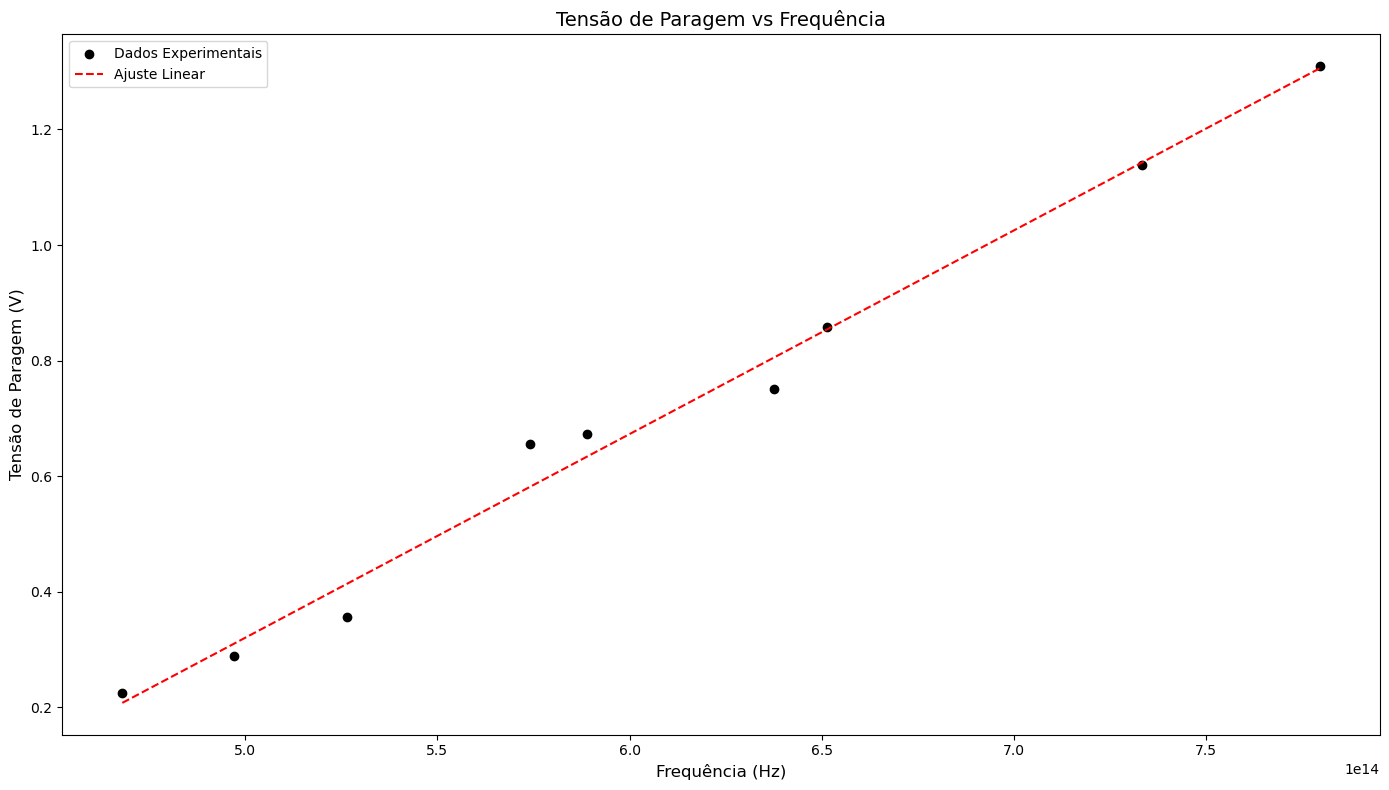

Resultados do Ajuste Linear:
Coeficiente Angular (h/e): 3.525e-15 V·s
Constante de Planck (h): 5.647e-34 J·s ± 4.30%
Intercept (-φ/e): -1.442e+00 V
Função Trabalho (φ): 2.310e-19 J
Coeficiente de Determinação (R²): 0.9872


In [8]:
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

# Velocidade da luz em m/s
c = 3e8

# Tensão de paragem para cada LED (excluindo LED 6)
tensao_paragem = {
    1: 1.3096, 2: 1.1387, 3: 0.8578, 4: 0.7506, 5: 0.6557,
    7: 0.2892, 8: 0.2246, 10: 0.3557, 11: 0.6730  # Excluído LED 6
}

# Incertezas associadas às tensões de paragem (em percentagem)
incertezas_tensao = {
    1: 0.20, 2: 0.13, 3: 0.11, 4: 0.03, 5: 0.53,
    7: 4.59, 8: 5.08, 10: 5.28, 11: 0.10
}

# Listas para armazenar frequências, tensões e suas incertezas
frequencias = []
tensoes = []
incertezas = []

# Iterar sobre os LEDs disponíveis
for i in range(1, 12):
    if i in [6, 9]:  # Saltar os LEDs 6 e 9
        continue

    # Carregar os dados do ficheiro
    arquivo = f"/Users/emanuelmiranda/Desktop/Exp2/Dados/led{i}.txt"
    wavelengths, intensities = carregar_dados(arquivo)
    
    if wavelengths.size > 0 and intensities.size > 0:
        # Identificar o comprimento de onda do pico (em nm)
        pico_idx = np.argmax(intensities)
        pico_wavelength_nm = wavelengths[pico_idx]
        
        # Converter o comprimento de onda para frequência (em Hz)
        pico_wavelength_m = pico_wavelength_nm * 1e-9  # Converter nm para metros
        frequencia = c / pico_wavelength_m
        
        # Guardar a frequência, tensão de paragem e a incerteza
        frequencias.append(frequencia)
        tensoes.append(tensao_paragem[i])
        incertezas.append(tensao_paragem[i] * incertezas_tensao[i] / 100)  # Incerteza em Volts

# Converter listas para arrays numpy para facilitar operações
frequencias = np.array(frequencias)
tensoes = np.array(tensoes)
incertezas = np.array(incertezas)

# Ajuste linear
slope, intercept, r_value, p_value, std_err = linregress(frequencias, tensoes)

# Gerar a linha ajustada
frequencias_fit = np.linspace(min(frequencias), max(frequencias), 1000)
tensoes_fit = slope * frequencias_fit + intercept

# Constantes físicas
e = 1.602e-19  # Carga do elétron em C

# Calcular a constante de Planck
h = slope * e  # h = slope * e
phi = -intercept * e  # φ = -intercept * e

# Calcular a incerteza na constante de Planck considerando a incerteza no slope
h_incerteza = std_err * e  # Incerteza na constante de Planck (h = m * e)
phi_incerteza = std_err * e  # Incerteza na função trabalho

# Calcular a incerteza em percentagem
h_incerteza_percent = (h_incerteza / h) * 100  # Incerteza em percentagem para a constante de Planck
phi_incerteza_percent = (phi_incerteza / phi) * 100  # Incerteza em percentagem para a função trabalho

# Criar o gráfico
plt.figure(figsize=(14, 8))
plt.scatter(frequencias, tensoes, color='black', label="Dados Experimentais")
plt.plot(frequencias_fit, tensoes_fit, color='red', linestyle='--', label="Ajuste Linear")

# Adicionar rótulos e título
plt.title('Tensão de Paragem vs Frequência', fontsize=14)
plt.xlabel('Frequência (Hz)', fontsize=12)
plt.ylabel('Tensão de Paragem (V)', fontsize=12)
plt.legend()
plt.tight_layout()

# Mostrar o gráfico
plt.show()

# Mostrar os resultados do ajuste
print("Resultados do Ajuste Linear:")
print(f"Coeficiente Angular (h/e): {slope:.3e} V·s")
print(f"Constante de Planck (h): {h:.3e} J·s ± {h_incerteza_percent:.2f}%")
print(f"Intercept (-φ/e): {intercept:.3e} V")
print(f"Função Trabalho (φ): {phi:.3e} J")
print(f"Coeficiente de Determinação (R²): {r_value**2:.4f}")

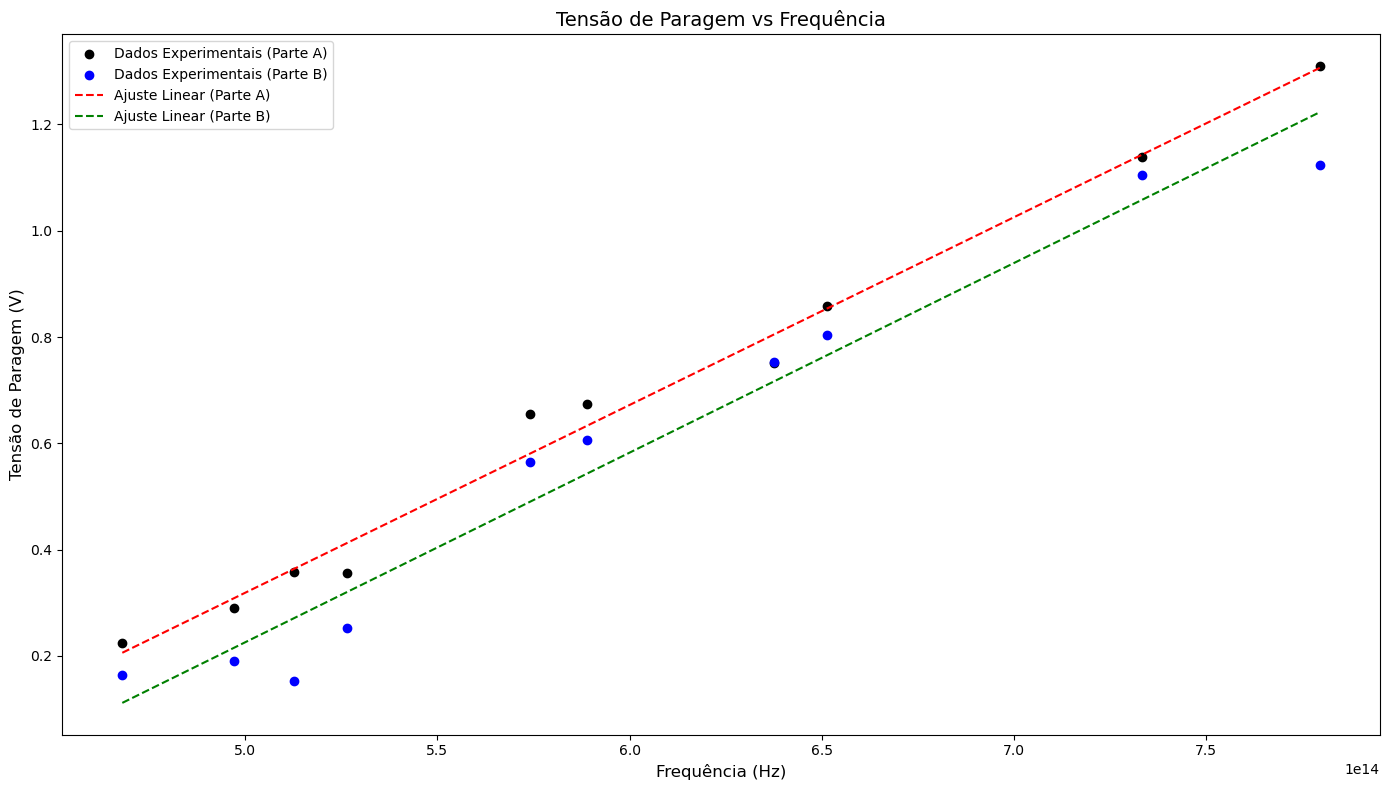

Resultados do Ajuste Linear (Parte A):
Coeficiente Angular (h/e): 3.533e-15 V·s
Constante de Planck (h): 5.659e-34 J·s
Intercept (-φ/e): -1.447e+00 V
Função Trabalho (φ): 2.319e-19 J
Coeficiente de Determinação (R²): 0.9883
Incerteza Relativa (Parte A): 3.85%

Resultados do Ajuste Linear (Parte B):
Coeficiente Angular (h/e): 3.568e-15 V·s
Constante de Planck (h): 5.715e-34 J·s
Intercept (-φ/e): -1.558e+00 V
Função Trabalho (φ): 2.496e-19 J
Coeficiente de Determinação (R²): 0.9630
Incerteza Relativa (Parte B): 6.93%


In [9]:
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

# Velocidade da luz em m/s
c = 3e8

# Tensão de paragem para cada LED (dados anteriores)
tensao_paragem_anterior = {
    1: 1.3096, 2: 1.1387, 3: 0.8578, 4: 0.7506, 5: 0.6557,
    6: 0.3570, 7: 0.2892, 8: 0.2246, 10: 0.3557, 11: 0.6730
}

# Novas tensões de paragem com condensador
tensao_condensador = {
    1: 1.1232, 2: 1.10478, 3: 0.80421, 4: 0.75256, 5: 0.56482,
    6: 0.15244, 7: 0.18998, 8: 0.16378, 10: 0.25178, 11: 0.60653
}

# Listas para armazenar frequências e tensões
frequencias = []
tensoes_anterior = []
tensoes_condensador = []

# Iterar sobre os LEDs disponíveis
for i in range(1, 12):
    if i == 9:  # Saltar o LED 9
        continue

    # Carregar os dados do ficheiro
    arquivo = f"/Users/emanuelmiranda/Desktop/Exp2/Dados/led{i}.txt"
    wavelengths, intensities = carregar_dados(arquivo)
    
    if wavelengths.size > 0 and intensities.size > 0:
        # Identificar o comprimento de onda do pico (em nm)
        pico_idx = np.argmax(intensities)
        pico_wavelength_nm = wavelengths[pico_idx]
        
        # Converter o comprimento de onda para frequência (em Hz)
        pico_wavelength_m = pico_wavelength_nm * 1e-9  # Converter nm para metros
        frequencia = c / pico_wavelength_m
        
        # Guardar a frequência e as tensões de paragem
        frequencias.append(frequencia)
        tensoes_anterior.append(tensao_paragem_anterior[i])
        tensoes_condensador.append(tensao_condensador[i])

# Converter listas para arrays numpy para facilitar operações
frequencias = np.array(frequencias)
tensoes_anterior = np.array(tensoes_anterior)
tensoes_condensador = np.array(tensoes_condensador)

# Ajuste linear para os dados sem condensador
slope_anterior, intercept_anterior, r_value_anterior, p_value_anterior, std_err_anterior = linregress(frequencias, tensoes_anterior)

# Ajuste linear para os dados com condensador
slope_condensador, intercept_condensador, r_value_condensador, p_value_condensador, std_err_condensador = linregress(frequencias, tensoes_condensador)

# Gerar a linha ajustada para ambos os casos
frequencias_fit = np.linspace(min(frequencias), max(frequencias), 1000)
tensoes_fit_anterior = slope_anterior * frequencias_fit + intercept_anterior
tensoes_fit_condensador = slope_condensador * frequencias_fit + intercept_condensador

# Calcular a incerteza relativa (em percentagem)
incerteza_relativa_anterior = (std_err_anterior / slope_anterior) * 100
incerteza_relativa_condensador = (std_err_condensador / slope_condensador) * 100

# Criar o gráfico
plt.figure(figsize=(14, 8))
plt.scatter(frequencias, tensoes_anterior, color='black', label="Dados Experimentais (Parte A)")
plt.scatter(frequencias, tensoes_condensador, color='blue', label="Dados Experimentais (Parte B)")
plt.plot(frequencias_fit, tensoes_fit_anterior, color='red', linestyle='--', label="Ajuste Linear (Parte A)")
plt.plot(frequencias_fit, tensoes_fit_condensador, color='green', linestyle='--', label="Ajuste Linear (Parte B)")

# Adicionar rótulos e título
plt.title('Tensão de Paragem vs Frequência', fontsize=14)
plt.xlabel('Frequência (Hz)', fontsize=12)
plt.ylabel('Tensão de Paragem (V)', fontsize=12)
plt.legend()
plt.tight_layout()

# Mostrar o gráfico
plt.show()

# Mostrar os resultados do ajuste
print("Resultados do Ajuste Linear (Parte A):")
print(f"Coeficiente Angular (h/e): {slope_anterior:.3e} V·s")
print(f"Constante de Planck (h): {slope_anterior * 1.602e-19:.3e} J·s")
print(f"Intercept (-φ/e): {intercept_anterior:.3e} V")
print(f"Função Trabalho (φ): {-intercept_anterior * 1.602e-19:.3e} J")
print(f"Coeficiente de Determinação (R²): {r_value_anterior**2:.4f}")
print(f"Incerteza Relativa (Parte A): {incerteza_relativa_anterior:.2f}%")

print("\nResultados do Ajuste Linear (Parte B):")
print(f"Coeficiente Angular (h/e): {slope_condensador:.3e} V·s")
print(f"Constante de Planck (h): {slope_condensador * 1.602e-19:.3e} J·s")
print(f"Intercept (-φ/e): {intercept_condensador:.3e} V")
print(f"Função Trabalho (φ): {-intercept_condensador * 1.602e-19:.3e} J")
print(f"Coeficiente de Determinação (R²): {r_value_condensador**2:.4f}")
print(f"Incerteza Relativa (Parte B): {incerteza_relativa_condensador:.2f}%")


LED 1: Comprimento de onda do pico = 384.80 nm
LED 2: Comprimento de onda do pico = 409.13 nm
LED 3: Comprimento de onda do pico = 460.54 nm
LED 4: Comprimento de onda do pico = 470.59 nm
LED 5: Comprimento de onda do pico = 522.62 nm
LED 6: Comprimento de onda do pico = 585.03 nm
LED 7: Comprimento de onda do pico = 603.68 nm
LED 8: Comprimento de onda do pico = 641.03 nm
LED 9: Comprimento de onda do pico = 842.99 nm
LED 10: Comprimento de onda do pico = 569.86 nm
LED 11: Comprimento de onda do pico = 509.43 nm


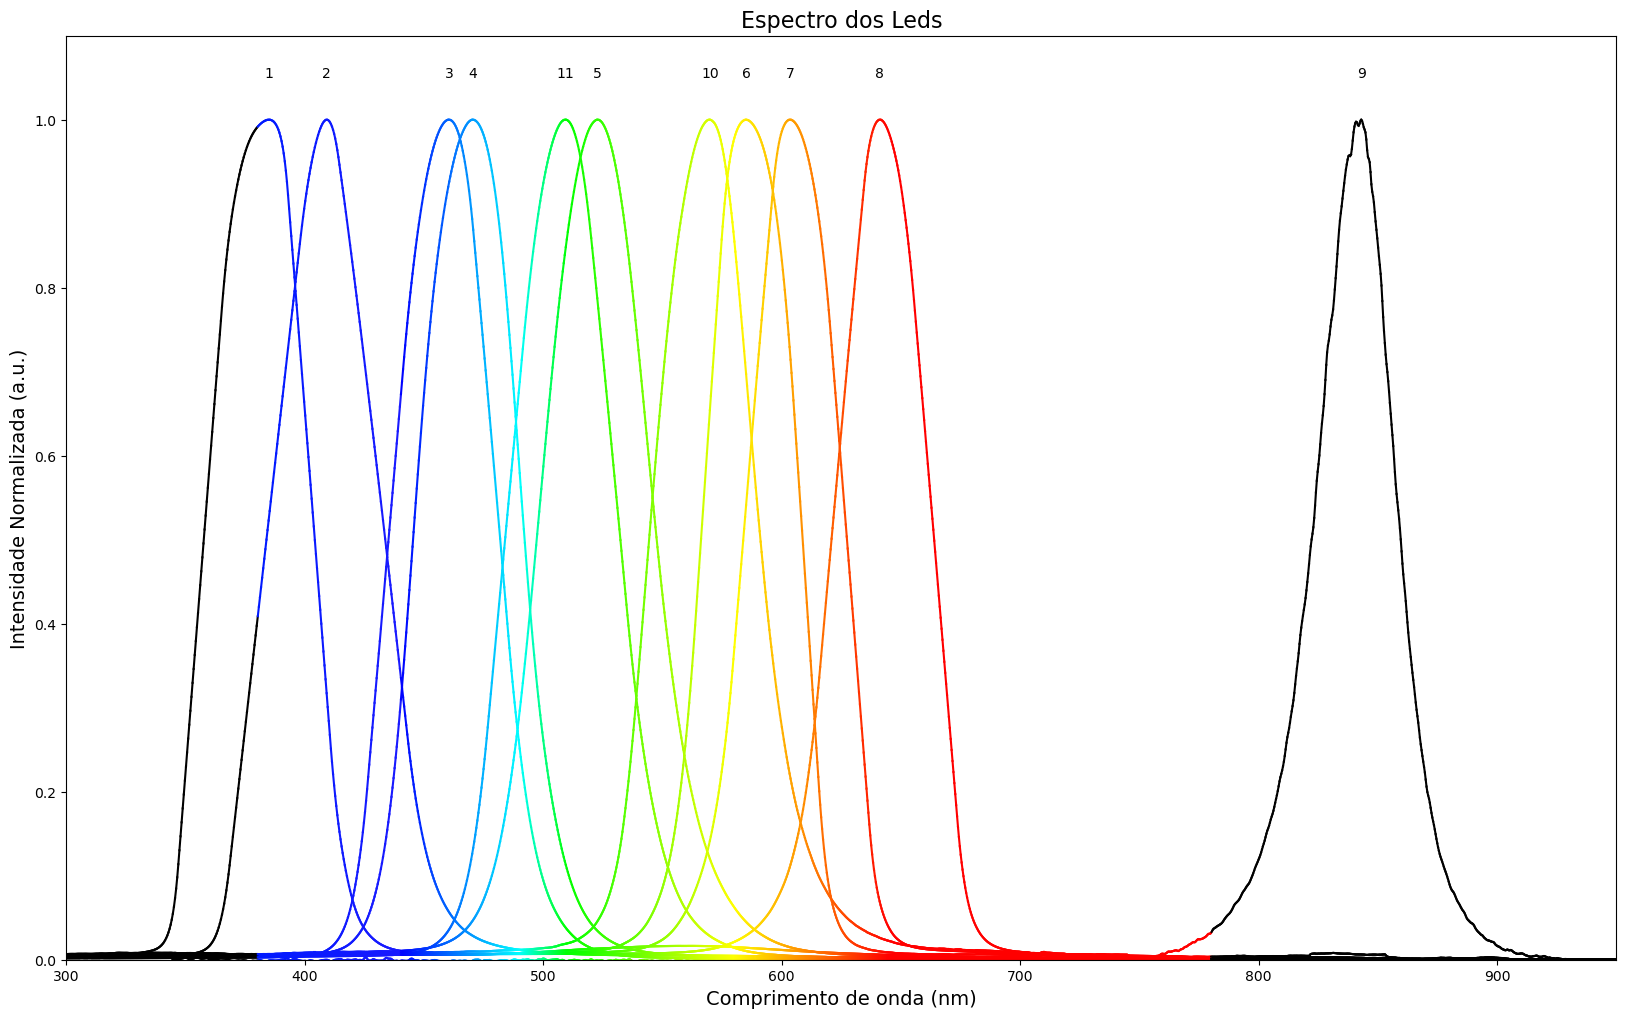

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Função para ler os dados de cada ficheiro
def carregar_dados(arquivo):
    wavelengths = []
    intensities = []
    try:
        with open(arquivo, "r") as data:
            read_data = False  # Sinalizador para começar a ler após o cabeçalho
            for line in data:
                # Verifica se chegamos à linha de dados
                if line.startswith("Pixel"):
                    read_data = True  # Inicia a leitura de dados na próxima linha
                    continue
                if read_data:
                    linha = line.strip().split()  # Divide por espaços ou tabulações
                    if len(linha) == 3:  # Verifica se há exatamente 3 colunas de dados
                        try:
                            wavelength = float(linha[1])  # Coluna 2 é Wavelength
                            intensity = float(linha[2])  # Coluna 3 é Intensity
                            wavelengths.append(wavelength)
                            intensities.append(intensity)
                        except ValueError:
                            print(f"Erro ao converter para float: {linha}")
    except FileNotFoundError:
        print(f"Arquivo {arquivo} não encontrado. Verifique o caminho.")
    return np.array(wavelengths), np.array(intensities)

# Criar o gráfico principal
plt.figure(figsize=(20, 12))

# Iterar sobre os números de 1 a 11
for i in range(1, 12):    
    arquivo = f"/Users/emanuelmiranda/Desktop/Exp2/Dados/led{i}.txt"  # Caminho para o ficheiro
    wavelengths, intensities = carregar_dados(arquivo)
    
    if wavelengths.size > 0 and intensities.size > 0:
        # Filtrar os valores na faixa de 900 a 1100 nm
        faixa_mask = (wavelengths >= 900) & (wavelengths <= 1100)
        media_faixa = np.mean(intensities[faixa_mask])  # Calcula a média das intensidades nessa faixa
        
        # Subtrair a média de todas as intensidades
        intensities_corrigidas = intensities - media_faixa
        
        # Normalizar as intensidades para que o pico seja igual a 1
        intensidade_max = np.max(intensities_corrigidas)  # Encontra o valor máximo
        if intensidade_max != 0:  # Evita divisão por zero
            intensities_normalizadas = intensities_corrigidas / intensidade_max
        else:
            intensities_normalizadas = intensities_corrigidas  # Caso o valor máximo seja zero

        # Função de mapeamento de cores
        def wavelength_to_rgb(wavelength):
            """Converte um comprimento de onda em uma cor RGB"""
            if wavelength < 380:
                return (0, 0, 0)  # Preto para comprimentos de onda abaixo de 380 nm
            elif wavelength < 440:
                return (0.1 * (wavelength - 380) / (440 - 380), 0.1, 1)  # Azul
            elif wavelength < 490:
                return (0, (wavelength - 440) / (490 - 440), 1)  # Azul a verde
            elif wavelength < 510:
                return (0, 1, (510 - wavelength) / (510 - 490))  # Verde
            elif wavelength < 580:
                return ((wavelength - 510) / (580 - 510), 1, 0)  # Verde a amarelo
            elif wavelength < 645:
                return (1, (645 - wavelength) / (645 - 580), 0)  # Amarelo a vermelho
            elif wavelength <= 780:
                return (1, 0, 0)  # Vermelho
            else:
                return (0, 0, 0)  # Preto para comprimentos de onda acima de 780 nm

        # Plotar os segmentos de linhas com cores de acordo com os comprimentos de onda
        for j in range(len(wavelengths) - 1):
            # Aplique a cor amarela a 589 nm
            if 589 <= wavelengths[j] <= 589.5:  # Verifica se está na vizinhança de 589 nm
                plt.plot(wavelengths[j:j + 2], intensities_normalizadas[j:j + 2], color='#ffe200')  # Cor amarela
            else:
                plt.plot(wavelengths[j:j + 2], intensities_normalizadas[j:j + 2], color=wavelength_to_rgb(wavelengths[j]))

        # Encontrar o pico e a posição do pico
        pico_idx = np.argmax(intensities_normalizadas)
        pico_wavelength = wavelengths[pico_idx]
        pico_intensity = intensities_normalizadas[pico_idx]
        
        # Adicionar o número do LED sobre o pico
        plt.text(pico_wavelength, pico_intensity + 0.05, f'{i}', ha='center', fontsize=10, color='black')
        
        # Imprimir o comprimento de onda do pico no terminal
        print(f"LED {i}: Comprimento de onda do pico = {pico_wavelength:.2f} nm")

# Título e rótulos
plt.title('Espectro dos Leds', fontsize=16)
plt.xlabel('Comprimento de onda (nm)', fontsize=14)
plt.ylabel('Intensidade Normalizada (a.u.)', fontsize=14)

# Ajusta o limite do eixo x para começar em 500 nm
plt.xlim(300, 950)

# Ajusta o limite do eixo y para começar em 0 (eliminar intensidades negativas)
plt.ylim(0, 1.1)  # Limita o eixo y para não ultrapassar o valor 1 após a normalização

# Exibir o gráfico
plt.show()
